In [28]:
#Author Farida Shagieva

import qutip as q
import numpy as np
import subprocess
import ffmpeg
import pickle
import cv2
import os
import re

%matplotlib inline
from matplotlib import rc
from matplotlib import pyplot as plt
font = {'weight' : 'normal',
        'size'   : 18}
rc('font', **font)

from matplotlib.font_manager import FontProperties

##### $H_{rot}= \Omega * S_x + \gamma_{n} *B_0*I_z + \hat{S}*A*\hat{I}$

In [5]:
Axx=65*10**3 # 20 kHz
B0=500.0 # Gauss
gamma_nuc = 42.576*1000000 # Hz/T
w_larmor=B0*gamma_nuc/10000

time_x=10*np.pi/Axx

iz = q.tensor(q.qeye(2),q.sigmaz())
ix = q.tensor(q.qeye(2),q.sigmax())
iy = q.tensor(q.qeye(2),q.sigmay())

# NV hamiltonian
sz = q.tensor(q.sigmaz(),q.qeye(2))
sx = q.tensor(q.sigmax(),q.qeye(2))
sy = q.tensor(q.sigmay(),q.qeye(2))

rho_nv = q.thermal_dm(2, 0.0) # initialized to 0 temperature
a=90
a /= 180/np.pi
phi = np.cos(a/2.)*q.basis(2,0)+np.sin(a/2.)*q.basis(2,1)

b=180
b /= 180/np.pi
phi_nuc = np.cos(b/2.)*q.basis(2,0)+(0+1j)*np.sin(b/2.)*q.basis(2,1)
rho_nv = phi*phi.dag()

rho_nuclear = q.thermal_dm(2, 1000)
#rho_nuclear = phi_nuc*phi_nuc.dag()
rho_total = q.tensor(rho_nv,rho_nuclear)

# b3d = q.Bloch()
# b3d.add_states(rho_nv)
# b3d.show()

# b3d2 = q.Bloch()
# b3d2.add_states(rho_nuclear)
# b3d2.show()

rho_nuclear

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.50024988 0.        ]
 [0.         0.49975012]]

In [6]:
Omega = w_larmor 

H0 = Omega * sx + w_larmor*iz + 0.5*sz*Axx*ix


In [7]:
t = np.linspace(0, time_x, 500)

resultat = q.mesolve(H=H0, rho0=rho_total, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=1000000))

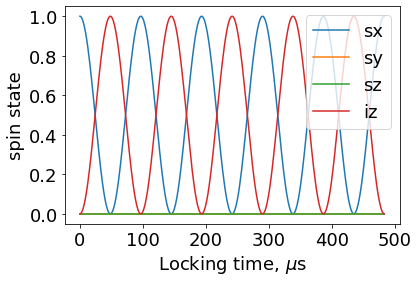

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t*1e+6, q.expect(resultat.states, sx),label='sx')
ax.plot(t*1e+6, q.expect(resultat.states, sy),label='sy')
ax.plot(t*1e+6, q.expect(resultat.states, sz),label='sz')
ax.plot(t*1e+6, q.expect(resultat.states, iz),label='iz')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.legend(loc='upper right')

ax.set_ylabel('spin state')
ax.set_xlabel(r'Locking time, $\mu$s')

fig.savefig('polarization.png', bbox_inches='tight', dpi=300)

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:456: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:456: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])


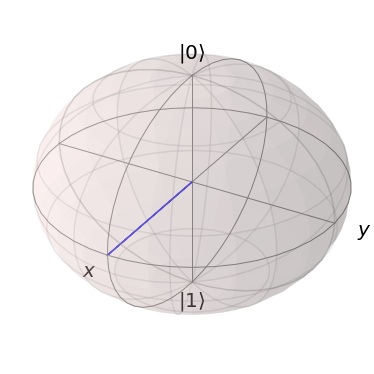

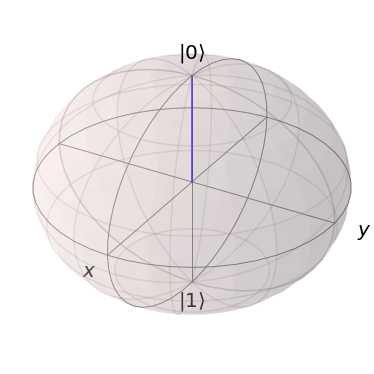

In [9]:
b3d = q.Bloch()
b3d2 = q.Bloch()
#for st in resultat.states:
for op,bl in zip([[sx,sy,sz],[ix,iy,iz]],[b3d,b3d2]):
    bl.add_points(points=np.array([q.expect(op[0],resultat.states),q.expect(op[1],resultat.states),q.expect(op[2],resultat.states)]), meth='l')
b3d.show()
b3d2.show()

b3d.fig.savefig('Bloch.png')
b3d2.fig.savefig('Bloch_nucl.png')

In [10]:
b_nv = q.Bloch()
b_nucl = q.Bloch()

b_nv.vector_color = ['r']
b_nucl.vector_color = ['b']

for op,bl in zip([[sx,sy,sz],[ix,iy,iz]],[b_nv, b_nucl]):
    b_nv.clear()
    b_nucl.clear()
    
    bl.add_vectors(np.array([q.expect(op[0],resultat.states),q.expect(op[1],resultat.states),q.expect(op[2],resultat.states)]))
    bl.add_points(points=np.array([q.expect(op[0],resultat.states),q.expect(op[1],resultat.states),q.expect(op[2],resultat.states)]),meth='l')
    
for i in range(len(resultat.states)):
    b_nv.clear()
    b_nucl.clear()
    
    b_nv.add_vectors(np.array([q.expect(sx,resultat.states[i]),q.expect(sy,resultat.states[i]),q.expect(sz,resultat.states[i])]))
    b_nucl.add_vectors(np.array([q.expect(ix,resultat.states[i]),q.expect(iy,resultat.states[i]),q.expect(iz,resultat.states[i])]))
    
    b_nv.save(dirc='temp')
    b_nucl.save(dirc='temp1')

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:456: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:456: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fi

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/jonny/.local/lib/python3.8/site-packages/qutip/bloch.py:59: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 an

In [24]:
import sys
from PIL import Image

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

import os

image_folder1 = os.path.join(os.getcwd(),'temp','') #'/home/striebel/Documents/Jupyter_notebooks/temp/'
image_folder2 = os.path.join(os.getcwd(),'temp1','') #'/home/striebel/Documents/Jupyter_notebooks/temp1/'

images1 = [img for img in os.listdir(image_folder1) if img.endswith(".png")]
images1.sort(key=natural_keys)

images2 = [img for img in os.listdir(image_folder2) if img.endswith(".png")]
images2.sort(key=natural_keys)

for i in range(5):

    images = map(Image.open, [image_folder1+images1[i], image_folder2+images2[i]])
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save('new_' + str(i) + '.png')

In [25]:
for i in range(len(images1)):

    images = map(Image.open, [image_folder1+images1[i], image_folder2+images2[i]])
    
    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save('new_' + str(i) + '.png')

In [26]:
image_folder = os.path.join(os.getcwd(),'') #'/home/striebel/Documents/Jupyter_notebooks/'
video_name = 'video.avi'

os.listdir(image_folder)
images = [img for img in os.listdir(image_folder) if img.startswith("new_")]
images.sort(key=natural_keys)
images

['new_0.png',
 'new_1.png',
 'new_2.png',
 'new_3.png',
 'new_4.png',
 'new_5.png',
 'new_6.png',
 'new_7.png',
 'new_8.png',
 'new_9.png',
 'new_10.png',
 'new_11.png',
 'new_12.png',
 'new_13.png',
 'new_14.png',
 'new_15.png',
 'new_16.png',
 'new_17.png',
 'new_18.png',
 'new_19.png',
 'new_20.png',
 'new_21.png',
 'new_22.png',
 'new_23.png',
 'new_24.png',
 'new_25.png',
 'new_26.png',
 'new_27.png',
 'new_28.png',
 'new_29.png',
 'new_30.png',
 'new_31.png',
 'new_32.png',
 'new_33.png',
 'new_34.png',
 'new_35.png',
 'new_36.png',
 'new_37.png',
 'new_38.png',
 'new_39.png',
 'new_40.png',
 'new_41.png',
 'new_42.png',
 'new_43.png',
 'new_44.png',
 'new_45.png',
 'new_46.png',
 'new_47.png',
 'new_48.png',
 'new_49.png',
 'new_50.png',
 'new_51.png',
 'new_52.png',
 'new_53.png',
 'new_54.png',
 'new_55.png',
 'new_56.png',
 'new_57.png',
 'new_58.png',
 'new_59.png',
 'new_60.png',
 'new_61.png',
 'new_62.png',
 'new_63.png',
 'new_64.png',
 'new_65.png',
 'new_66.png',
 'new

In [27]:
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 20, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()